# Anemia en Diálisis Peritoneal

In [1]:
from lifelines import CoxPHFitter
from lifelines import CoxTimeVaryingFitter
from lifelines.utils import to_long_format
from lifelines.utils import add_covariate_to_timeline
import matplotlib.pyplot as plt
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest

import anemiaLevanteDP as a

## Load Data

In [2]:
# Load the data
lab_base_df = pd.read_pickle('Analíticas.pkl')
pac__base_df = pd.read_pickle('Pacientes.pkl')
hosp_base_df = pd.read_pickle('Ingresos.pkl')
per_base_df = pd.read_pickle('Peritonitis.pkl')

# Merge labs with patients

merged_base_df = pd.merge(lab_base_df, pac__base_df, on='REGISTRO', how='left')

## Preprocesado de datos

In [3]:
# Cols to calculate baseline
baseline_cat_cols = ['SEXO', 'CKD_STAGE', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR']
baseline_num_cols = ['EDAD', 'CKD_CALC', 'GLUCOSA', 'UREA', 'CREATININA', 'URICO', 'SODIO', 'POTASIO', 'CALCIO', 'FOSFORO', 'HIERRO', 'TRANSFERRINA', 'IST', 'FERRITINA', 'COLESTEROL', 'TRIGLICERIDOS', 'HDL', 'LDL', 'LEUCOCITOS', 'NEUTROFILOS', 'LINFOCITOS', 'MONOCITOS', 'EOSINOFILOS', 'BASOFILOS', 'GRANULOCITOS', 'HEMATIES', 'HEMOGLOBINA', 'HEMATOCRITO', 'VCM', 'HCM', 'CHCM', 'PLAQUETAS', 'PLAQUETOCRITO', 'VPM']

# Cols to clean rows without info
basic_cols_lab = ['REGISTRO', 'FECHA', 'HEMOGLOBINA', 'HIERRO', 'TRANSFERRINA', 'IST', 'INICIO_DP', 'NACIMIENTO']
basic_cols_hosp = ['REGISTRO', 'FINGRESO']
basic_cols_per = ['REGISTRO', 'FECHA']

# Cols that must be deleted if it constains 0 as value

not_zero_cols = ['EDAD', 'GLUCOSA']

# Cols for cox model
bool_col_list = ['CARDIORENAL', 'PASO_A_HD', 'ARRITMIA', 'ITU', 'TBC', 'DM', 'VC', 'DIVERT', 'NEO', 'CH', 'SIST', 'EPOC', 'CARDIO', 'VP', 'DISLIPEMIA', 'FRAGNOS', 'DIURETICO', 'CALCIOANTA', 'IECA', 'ARAII', 'BBLOQUEANTE', 'ABLOQUEANTE', 'ABBLOQUEANTE', 'AGONISTASC', 'VASODILATADOR', 'OTROSFR', 'CIRUGIA']
covariate_list = ['HEMOGLOBINA', 'IST', 'HIERRO', 'FERRITINA']
exclude_list = ['TBC', 'CH', 'SIST', 'CARDIO', 'VP', 'VC', 'NEO', 'DIVERT']

In [4]:
# Clean NaNs for interesting columns
lab_df = a.clean_df(merged_base_df, basic_cols_lab, verbose=True)
lab_df = a.clean_df(lab_df, covariate_list, verbose=True)
hosp_df = a.clean_df(hosp_base_df, basic_cols_hosp, verbose=True)
per_df = a.clean_df(per_base_df, basic_cols_per, verbose=True)

# Select years
lab_df, hosp_df, per_df = a.filter_by_year([lab_df, hosp_df, per_df], ['FECHA', 'FINGRESO', 'FECHA'], 2010, 2023)

# Add anemia column based on 'HEMOGLOBINA' and 'SEXO' specified in KDIGO guidelines
a.add_anemia_column(lab_df)
a.add_age_column(lab_df)
a.add_ckd_column(lab_df)

# Delete rows that have 0 as values for not_zero_cols

lab_df = a.clean_zero_values(lab_df, not_zero_cols, verbose=True)

# Fill empty values for bool_cols
lab_df = a.bool_col_convert(lab_df, bool_col_list)

# Exclude patients with exclude_list
#lab_df = lab_df[lab_df['ICEDAD'] <= 11]
lab_df = a.exclude_patients(lab_df, exclude_list, verbose=True)

# Add days since the start of pd for every column in both dataframes
lab_df = a.add_days_since_start(lab_df, lab_df, 'FECHA')
hosp_df = a.add_days_since_start(lab_df, hosp_df, 'FINGRESO')
per_df = a.add_days_since_start(lab_df, per_df, 'FECHA')

# Now keep only the first year after the patients started PD
lab_df = a.filter_df(lab_df, 'days_since_start', 0, (365), verbose=True)
hosp_df = a.filter_df(hosp_df, 'days_since_start', 0, (365), verbose=True)
per_df = a.filter_df(per_df, 'days_since_start', 0, (365), verbose=True)

# Create the cox_df with all necessary data
cox_df = a.prepare_cox_df(lab_df, hosp_df, covariate_list)
cox_time_varying_df = a.cox_time_varying_prep(lab_df, hosp_df, covariate_list, 365)

cox_df_per = a.prepare_cox_df(lab_df, per_df, covariate_list)

The dataframe had 16507 rows (Unique patients: 1915), after the clean up of missing values, it has 8766 rows (Unique patients: 1248)
The dataframe had 8766 rows (Unique patients: 1248), after the clean up of missing values, it has 8723 rows (Unique patients: 1241)
The dataframe had 4680 rows (Unique patients: 2100), after the clean up of missing values, it has 2107 rows (Unique patients: 1002)
The dataframe had 4342 rows (Unique patients: 2019), after the clean up of missing values, it has 4311 rows (Unique patients: 2011)
Number of rows before deleting: 8568
Number of rows deleted: 5
Total number of rows after deleting: 8563
Rows before excluding patients: 8563
Rows after excluding patients: 4004
Percentage of deleted rows: 53.24068667523064%
Rows before filter: 4004 (Unique patients: 632)
Rows after filter: 1770 (Unique patients: 521)
Rows before filter: 346 (Unique patients: 180)
Rows after filter: 126 (Unique patients: 93)
Rows before filter: 334 (Unique patients: 181)
Rows after f

## 6.1 Cox hemoglobina - hospitalización

<lifelines.CoxPHFitter: fitted with 521 total observations, 442 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 521
number of events observed = 79
   partial log-likelihood = -473.59
         time fit was run = 2024-05-23 15:21:35 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.22      0.80      0.09           -0.41           -0.04                0.66                0.96
IST          0.07      1.07      0.02            0.02            0.11                1.02                1.12
HIERRO      -0.04      0.96      0.01           -0.06           -0.02                0.94                0.98
FERRITINA   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z      p  -log2(p)
covariate                                 
HEMOGLOBINA    0.00 -2.36   0.02      5.77
IST            0.00  2.91 <0.005      8.09
HIERRO         0.00 -3.94 <0.005     13.59
FERRITINA      0.00 -1.57   0.12      3.11
---
Concordance = 0.65
Partial AIC = 955.18
log-likelihood ratio test = 28.76 on 4 df
-log2(p) of ll-ratio test = 16.80

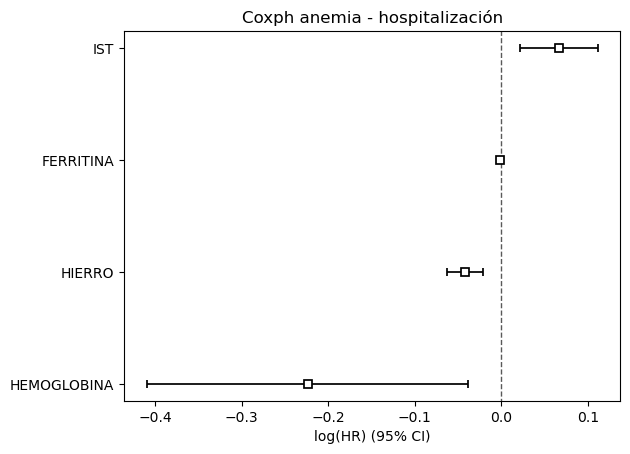

In [5]:
# Initialize the CoxPHFitter

cph_hosp = CoxPHFitter()

# Fit the data to the model
cph_hosp.fit(cox_df, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph_hosp.print_summary()

# Plot the coefficients of the model
cph_hosp.plot()
plt.title('Coxph anemia - hospitalización')
plt.show()

AUC: 0.6604043759665501


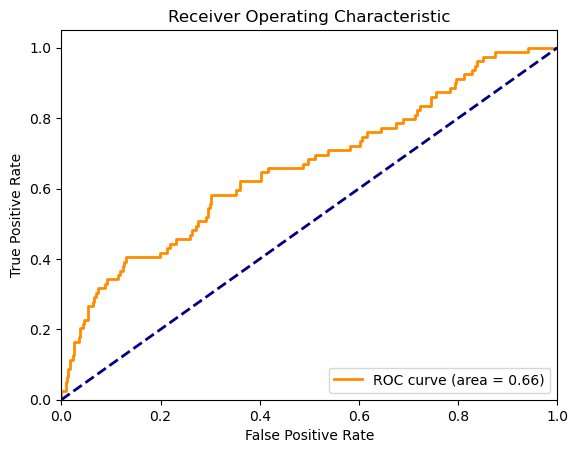

In [6]:
auc = a.evaluate_cox_model(cph_hosp, cox_df, 'finish_days', 'event_col', print_result=True)

In [7]:
a.calculate_residuals(cph_hosp, cox_df, martingale=True, schonenfeld=False)

Martingale Residuals:
      finish_days  event_col  martingale
70           4.0       True    0.994948
79           7.0       True    0.994176
444         10.0       True    0.992998
303         11.0       True    0.991826
413         19.0       True    0.976562
..           ...        ...         ...
516        365.0      False   -0.152070
517        365.0      False   -0.016514
518        365.0      False   -0.137651
519        365.0      False   -0.223642
520        365.0      False   -0.046864

[521 rows x 3 columns]


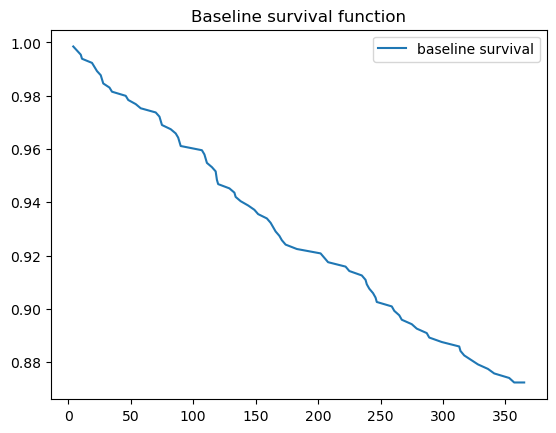

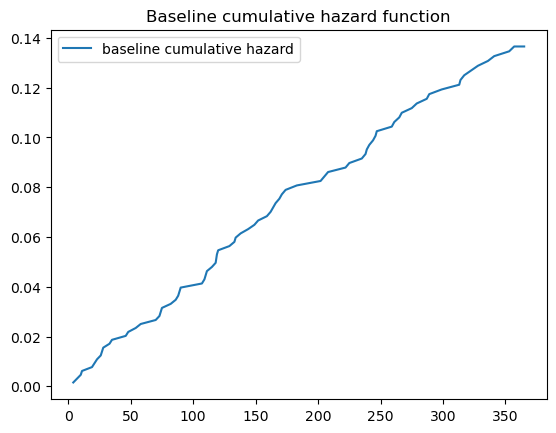


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


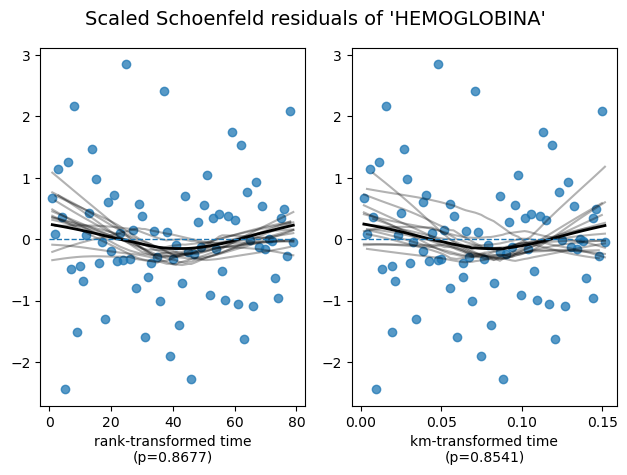

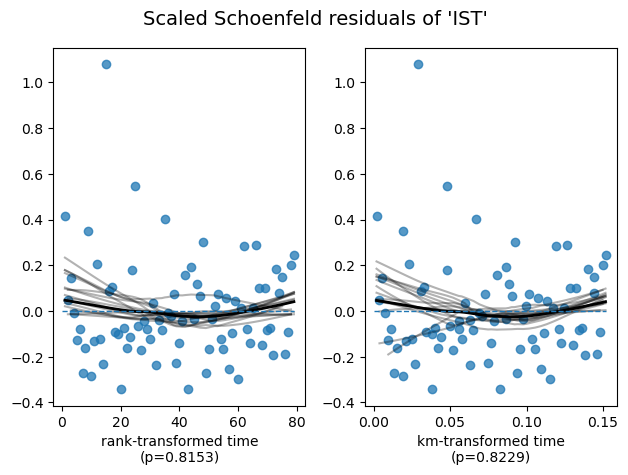

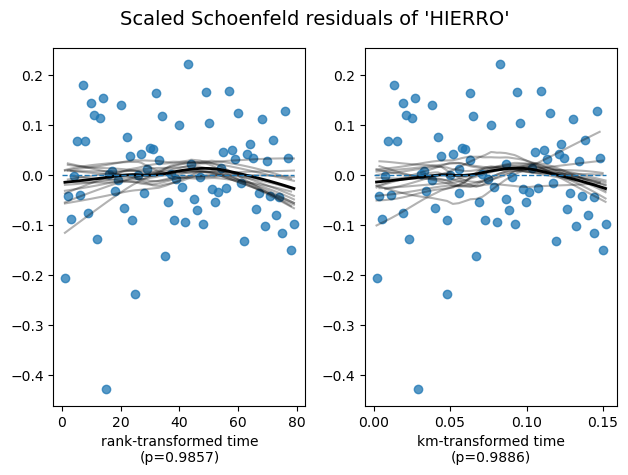

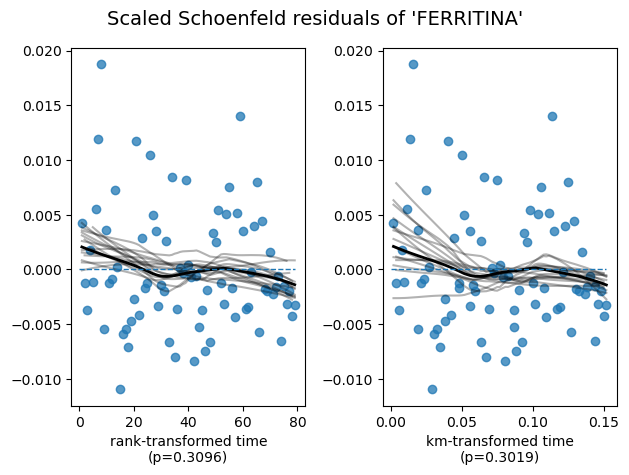

In [8]:
a.cox_visualization(cph_hosp, cox_df, survival_function=False, baseline_survival=True, baseline_cumulative_hazard=True, assumption=True) 

### Cox IST stratification and ROC curve (covariates)

CoxPHFitter results for IST between 0 and 20:


<lifelines.CoxPHFitter: fitted with 72 total observations, 58 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 72
number of events observed = 14
   partial log-likelihood = -54.41
         time fit was run = 2024-05-23 15:21:37 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.31      0.73      0.21           -0.72            0.09                0.49                1.09
IST          0.02      1.02      0.13           -0.23            0.26                0.80                1.30
HIERRO      -0.04      0.96      0.04           -0.13            0.04                0.88                1.04
FERRITINA   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -1.53 0.13      2.99
IST            0.00  0.15 0.88      0.18
HIERRO         0.00 -1.03 0.30      1.72
FERRITINA      0.00 -0.39 0.70      0.52
---
Concordance = 0.73
Partial AIC = 116.82
log-likelihood ratio test = 8.22 on 4 df
-log2(p) of ll-ratio test = 3.58

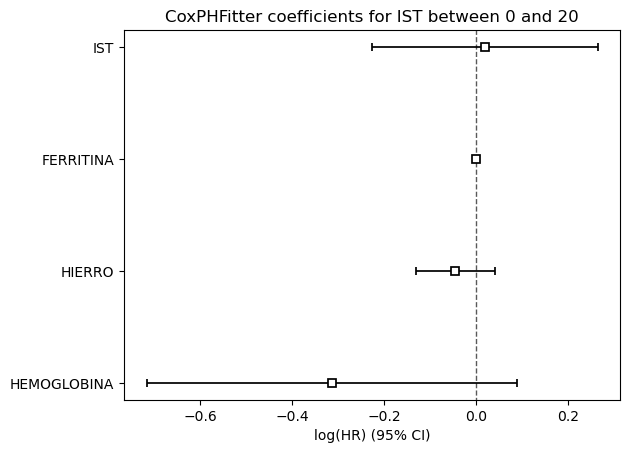

AUC for IST between 0 and 20: 0.7660098522167488


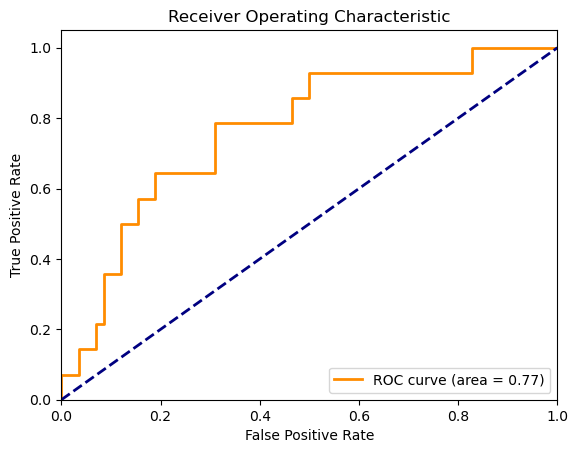

CoxPHFitter results for IST between 20 and 30:


<lifelines.CoxPHFitter: fitted with 242 total observations, 208 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 242
number of events observed = 34
   partial log-likelihood = -174.64
         time fit was run = 2024-05-23 15:21:37 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.37      0.69      0.15           -0.67           -0.07                0.51                0.93
IST          0.07      1.07      0.07           -0.08            0.21                0.93                1.24
HIERRO      -0.06      0.94      0.02           -0.10           -0.02                0.90                0.98
FERRITINA   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z      p  -log2(p)
covariate                                 
HEMOGLOBINA    0.00 -2.40   0.02      5.94
IST            0.00  0.94   0.35      1.53
HIERRO         0.00 -2.86 <0.005      7.87
FERRITINA      0.00 -1.46   0.15      2.78
---
Concordance = 0.68
Partial AIC = 357.29
log-likelihood ratio test = 19.09 on 4 df
-log2(p) of ll-ratio test = 10.37

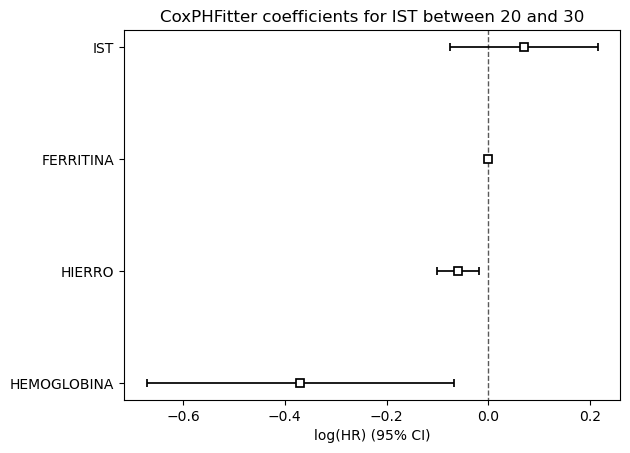

AUC for IST between 20 and 30: 0.6904694570135747


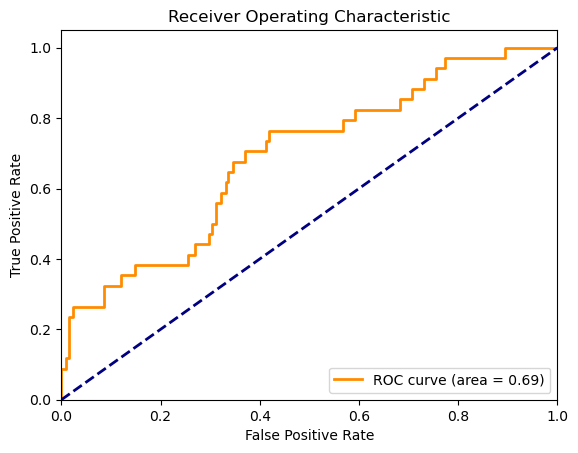

CoxPHFitter results for IST between 30 and 999:


<lifelines.CoxPHFitter: fitted with 207 total observations, 176 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 207
number of events observed = 31
   partial log-likelihood = -158.54
         time fit was run = 2024-05-23 15:21:37 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA  0.05      1.05      0.16           -0.25            0.36                0.78                1.43
IST          0.03      1.03      0.03           -0.03            0.10                0.97                1.10
HIERRO      -0.03      0.97      0.01           -0.06           -0.01                0.94                0.99
FERRITINA   -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00  0.34 0.74      0.44
IST            0.00  0.94 0.35      1.52
HIERRO         0.00 -2.58 0.01      6.68
FERRITINA      0.00 -0.68 0.50      1.00
---
Concordance = 0.62
Partial AIC = 325.08
log-likelihood ratio test = 8.81 on 4 df
-log2(p) of ll-ratio test = 3.92

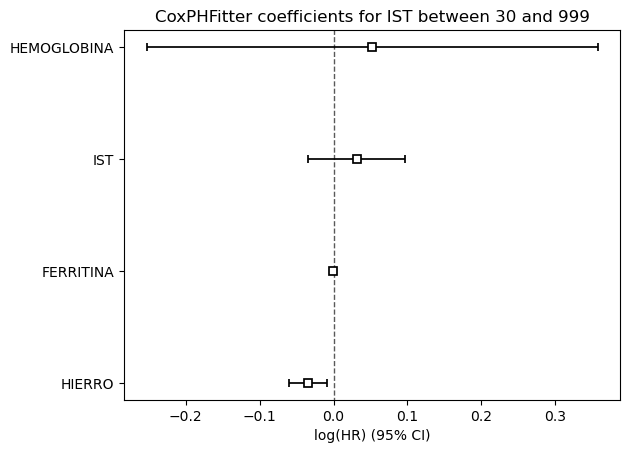

AUC for IST between 30 and 999: 0.6295821114369501


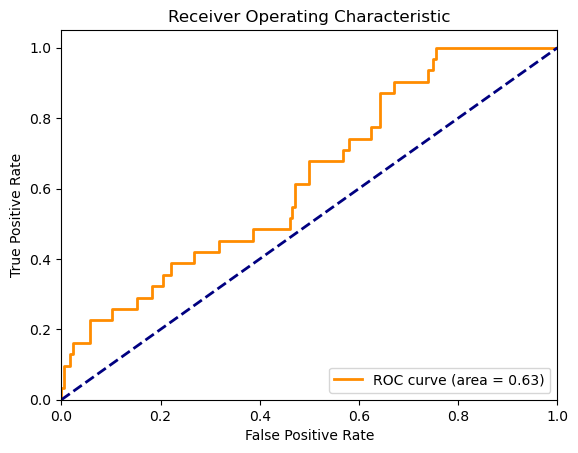

In [9]:
cph_models, aucs = a.stratified_cox(cox_df, 'finish_days', 'event_col', 'IST', [0, 20, 30, 999])

### Cox IST stratification and ROC curve (IST only, without covariates)

The dataframe had 16507 rows (Unique patients: 1915), after the clean up of missing values, it has 15741 rows (Unique patients: 1800)
The dataframe had 4680 rows (Unique patients: 2100), after the clean up of missing values, it has 2107 rows (Unique patients: 1002)
The dataframe had 15741 rows (Unique patients: 1800), after the clean up of missing values, it has 12701 rows (Unique patients: 1530)
Rows before excluding patients: 12701
Rows after excluding patients: 12701
Percentage of deleted rows: 0.0%
Rows before filter: 12701 (Unique patients: 1530)
Rows after filter: 5299 (Unique patients: 1321)
Rows before filter: 1284 (Unique patients: 596)
Rows after filter: 474 (Unique patients: 319)
CoxPHFitter results for IST between 0 and 20:


<lifelines.CoxPHFitter: fitted with 244 total observations, 231 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 13
   partial log-likelihood = -71.00
         time fit was run = 2024-05-23 15:21:38 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
IST       -0.04      0.96      0.08           -0.20            0.11                0.82                1.12

           cmp to     z    p  -log2(p)
covariate                             
IST          0.00 -0.54 0.59      0.77
---
Concordance = 0.51
Partial AIC = 143.99
log-likelihood ratio test = 0.28 on 1 df
-log2(p) of ll-ratio test = 0.75

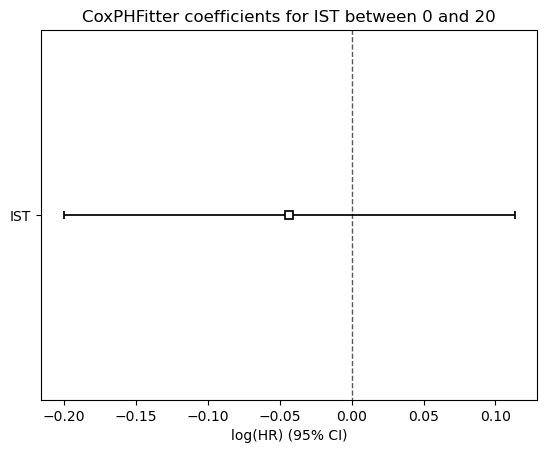

AUC for IST between 0 and 20: 0.5036630036630036


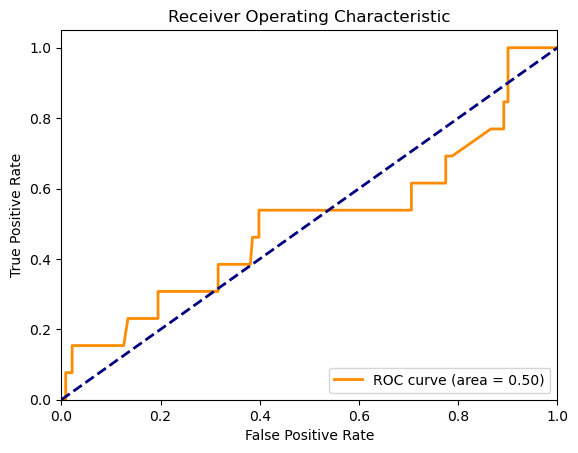

CoxPHFitter results for IST between 20 and 30:


<lifelines.CoxPHFitter: fitted with 618 total observations, 579 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 618
number of events observed = 39
   partial log-likelihood = -248.73
         time fit was run = 2024-05-23 15:21:38 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
IST       -0.06      0.94      0.06           -0.17            0.04                0.84                1.05

           cmp to     z    p  -log2(p)
covariate                             
IST          0.00 -1.16 0.25      2.01
---
Concordance = 0.55
Partial AIC = 499.47
log-likelihood ratio test = 1.35 on 1 df
-log2(p) of ll-ratio test = 2.02

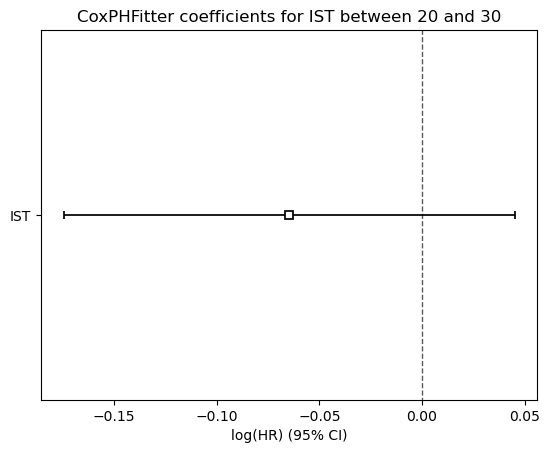

AUC for IST between 20 and 30: 0.5561976883220408


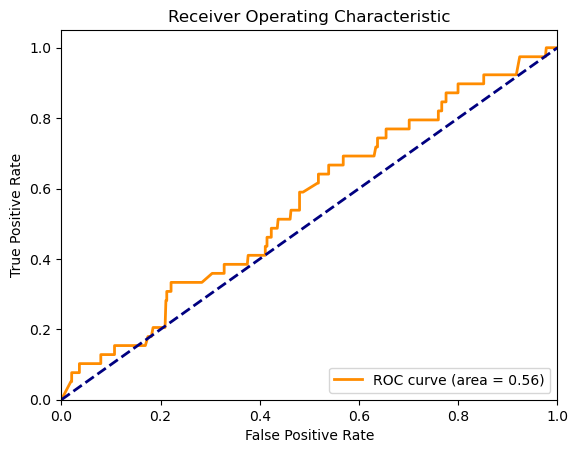

CoxPHFitter results for IST between 30 and 999:


<lifelines.CoxPHFitter: fitted with 459 total observations, 425 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 459
number of events observed = 34
   partial log-likelihood = -206.71
         time fit was run = 2024-05-23 15:21:39 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
IST       -0.02      0.98      0.02           -0.05            0.02                0.95                1.02

           cmp to     z    p  -log2(p)
covariate                             
IST          0.00 -0.86 0.39      1.35
---
Concordance = 0.51
Partial AIC = 415.42
log-likelihood ratio test = 0.85 on 1 df
-log2(p) of ll-ratio test = 1.49

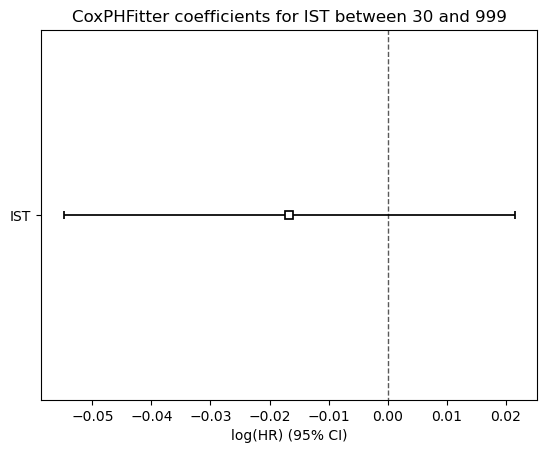

AUC for IST between 30 and 999: 0.5160553633217994


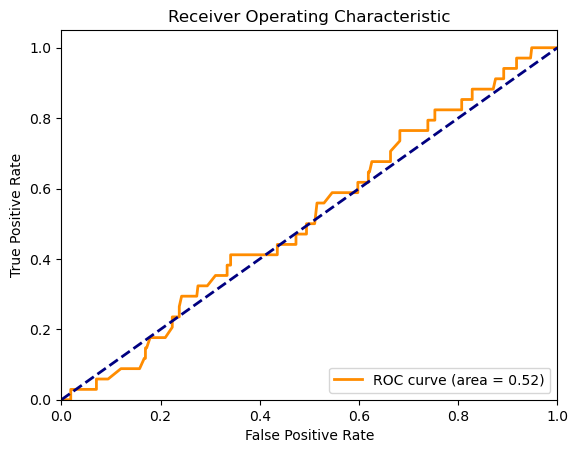

In [10]:
basic_cols_lab_strat = ['REGISTRO', 'FECHA', 'INICIO_DP', 'NACIMIENTO']
covariate_list_strat = ['IST']
bool_col_list_strat = []
exclude_list_strat = []
basic_cols_hosp_strat = ['REGISTRO', 'FINGRESO']



lab_strat_df = a.clean_df(merged_base_df, basic_cols_lab_strat, verbose=True)
hosp_strat_df = a.clean_df(pd.read_pickle('Ingresos.pkl'), basic_cols_hosp_strat, verbose=True)
lab_strat_df = a.clean_df(lab_strat_df, covariate_list_strat, verbose=True)

lab_strat_df = a.bool_col_convert(lab_strat_df, bool_col_list_strat)
lab_strat_df = a.exclude_patients(lab_strat_df, exclude_list_strat, verbose=True)

lab_strat_df = a.add_days_since_start(lab_strat_df, lab_strat_df, 'FECHA')
hosp_strat_df = a.add_days_since_start(lab_strat_df, hosp_strat_df, 'FINGRESO')

lab_strat_df = a.filter_df(lab_strat_df, 'days_since_start', 0, (365), verbose=True)
hosp_strat_df = a.filter_df(hosp_strat_df, 'days_since_start', 0, (365), verbose=True)

cox_strat_tsi_df = a.prepare_cox_df(lab_strat_df, hosp_df, covariate_list_strat)

cph_models, aucs = a.stratified_cox(cox_strat_tsi_df, 'finish_days', 'event_col', 'IST', [0, 20, 30, 999])

## 6.3 Cox hemoglobina - peritonitis

<lifelines.CoxPHFitter: fitted with 521 total observations, 451 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
                   strata = ['IST_binned', 'HIERRO_binned']
      baseline estimation = breslow
   number of observations = 521
number of events observed = 70
   partial log-likelihood = -400.34
         time fit was run = 2024-05-23 15:21:39 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.04      0.96      0.08           -0.19            0.12                0.83                1.12
IST          0.06      1.06      0.03            0.01            0.11                1.01                1.12
HIERRO      -0.02      0.98      0.01           -0.04           -0.00                0.96                1.00
FERRITINA    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -0.47 0.64      0.65
IST            0.00  2.25 0.02      5.34
HIERRO         0.00 -2.00 0.05      4.46
FERRITINA      0.00  0.47 0.64      0.65
---
Concordance = 0.56
Partial AIC = 808.69
log-likelihood ratio test = 7.34 on 4 df
-log2(p) of ll-ratio test = 3.07

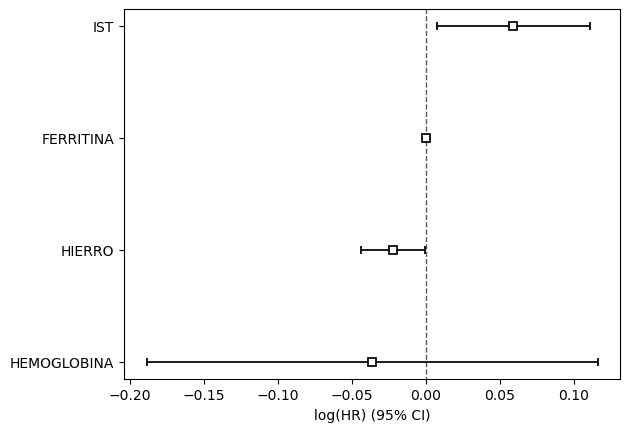

In [11]:
# Bin 'IST' and 'HIERRO' into discrete intervals
cox_df_per_bin = cox_df_per.copy()
cox_df_per_bin['IST_binned'] = pd.cut(cox_df_per_bin['IST'], bins=2, labels=False)
cox_df_per_bin['HIERRO_binned'] = pd.cut(cox_df_per_bin['HIERRO'], bins=2, labels=False)

# Initialize the CoxPHFitter
cph_per_bin = CoxPHFitter()

# Fit the data to the model with stratification on the binned variables
cph_per_bin.fit(cox_df_per_bin, duration_col='finish_days', event_col='event_col', strata=['IST_binned', 'HIERRO_binned'])

# Print the summary of the model
cph_per_bin.print_summary()

# Plot the coefficients of the model
cph_per_bin.plot()
plt.show()

#### Cox anemia-peritonitis residuals

Martingale Residuals:
      finish_days  event_col  martingale
223          4.0       True    0.996721
510          5.0       True    0.993814
116          7.0       True    0.995838
157          8.0       True    0.991067
81          13.0       True    0.989841
..           ...        ...         ...
476        365.0      False   -0.045359
495        365.0      False   -0.014512
501        365.0      False   -0.072931
504        365.0      False   -0.114094
520        365.0      False   -0.015900

[521 rows x 3 columns]


/opt/conda/lib/python3.11/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


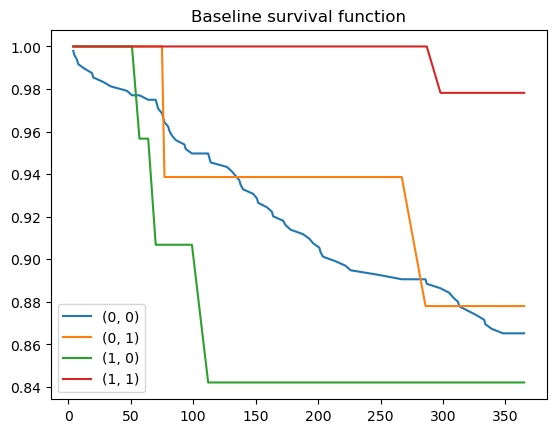

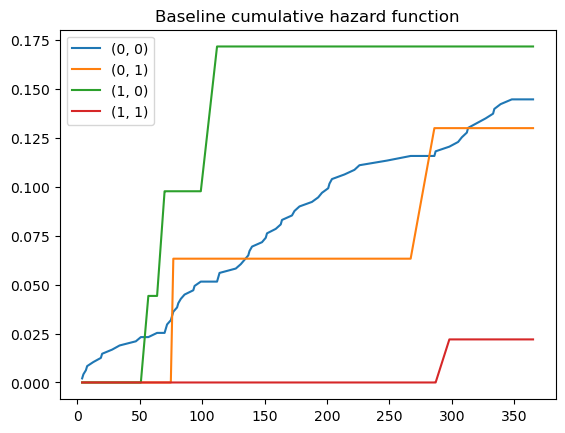


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


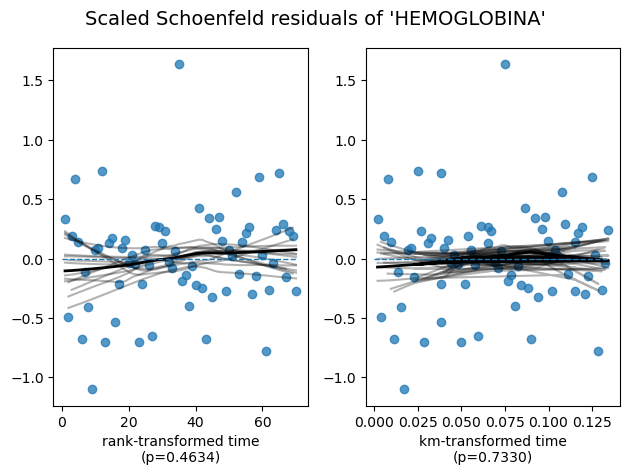

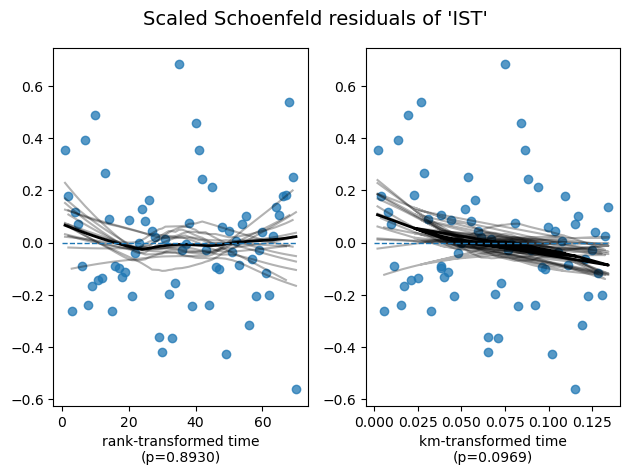

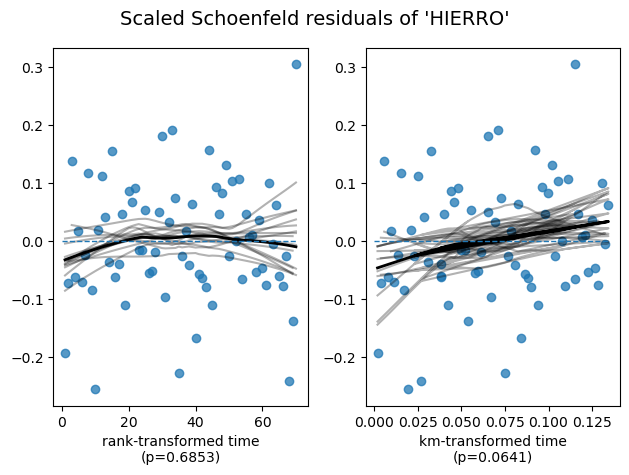

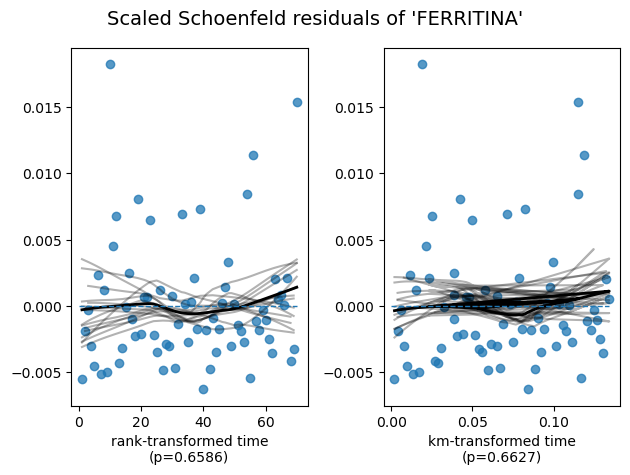

In [12]:
a.calculate_residuals(cph_per_bin, cox_df_per_bin, martingale=True, schonenfeld=False)
a.cox_visualization(cph_per_bin, cox_df_per_bin, survival_function=False, baseline_survival=True, baseline_cumulative_hazard=True, assumption=True) 

### Cox anemia-peritonitis without binning

<lifelines.CoxPHFitter: fitted with 521 total observations, 451 right-censored observations>
             duration col = 'finish_days'
                event col = 'event_col'
      baseline estimation = breslow
   number of observations = 521
number of events observed = 70
   partial log-likelihood = -428.55
         time fit was run = 2024-05-23 15:21:41 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.03      0.97      0.07           -0.17            0.11                0.84                1.12
IST          0.05      1.06      0.02            0.01            0.10                1.01                1.10
HIERRO      -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99
FERRITINA    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -0.41 0.68      0.55
IST            0.00  2.41 0.02      5.98
HIERRO         0.00 -2.66 0.01      7.00
FERRITINA      0.00  0.22 0.82      0.28
---
Concordance = 0.57
Partial AIC = 865.11
log-likelihood ratio test = 8.99 on 4 df
-log2(p) of ll-ratio test = 4.02

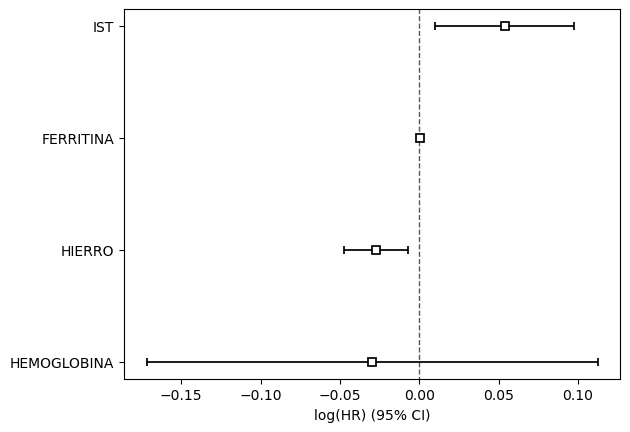

In [13]:
# Initialize the CoxPHFitter
cph_per = CoxPHFitter()

# Fit the data to the model with stratification on the binned variables
cph_per.fit(cox_df_per, duration_col='finish_days', event_col='event_col')

# Print the summary of the model
cph_per.print_summary()

# Plot the coefficients of the model
cph_per.plot()
plt.show()

#### Cox anemia - peritonitis without binning residuals

Martingale Residuals:
      finish_days  event_col  martingale
223          4.0       True    0.996655
510          5.0       True    0.994466
116          7.0       True    0.996481
157          8.0       True    0.991564
81          13.0       True    0.991358
..           ...        ...         ...
515        365.0      False   -0.125599
516        365.0      False   -0.100709
518        365.0      False   -0.128821
519        365.0      False   -0.164249
520        365.0      False   -0.066645

[521 rows x 3 columns]


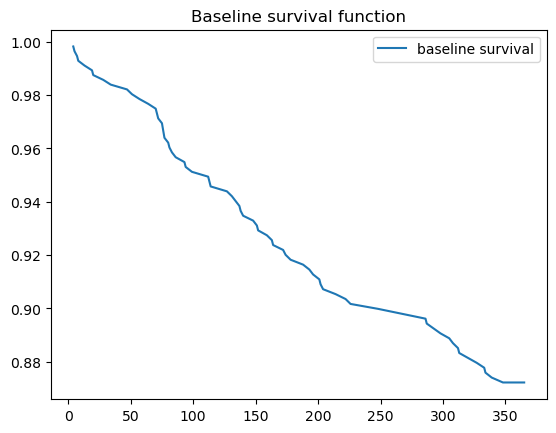

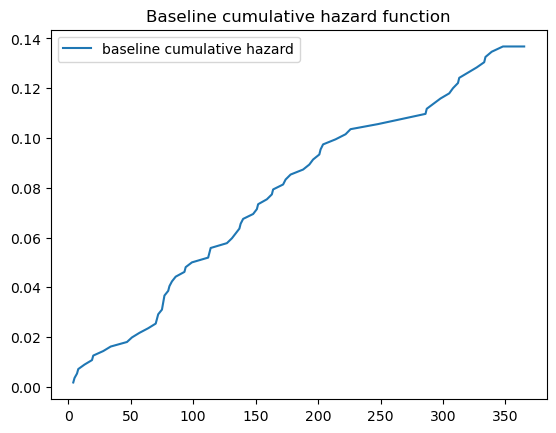


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 521 total observations, 451 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic    p  -log2(p)
FERRITINA   km              0.56 0.45      1.14
            rank            0.54 0.46      1.11
HEMOGLOBINA km              0.08 0.78      0.35
            rank            0.07 0.79      0.34
HIERRO      km              5.29 0.02      5.54
            rank            5.21 0.02      5.48
IST         km              4.75 0.03      5.09
            rank            4.67 0.03      5.03



1. Variable 'IST' failed the non-proportional test: p-value is 0.0293.

   Advice 1: the functional form of the variable 'IST' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'IST' using pd.cut, and then specify it in `strata=['IST',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'HIERRO' failed the non-proportional test: p-value is 0.0214.

   Advice 1: the functional form of the variable 'HIERRO' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below 

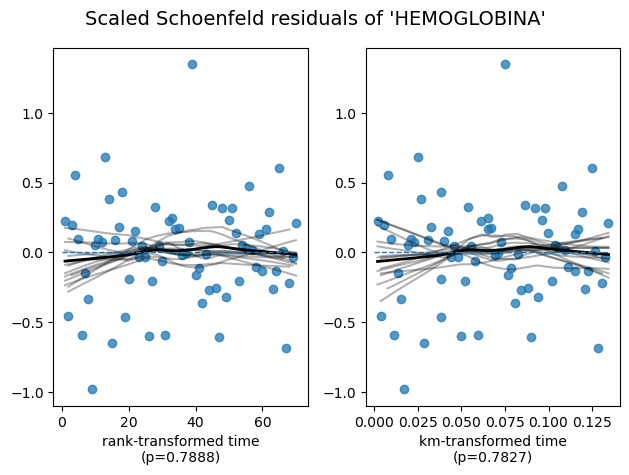

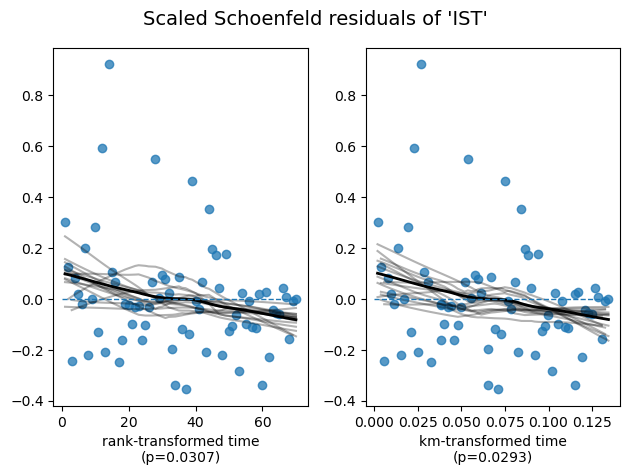

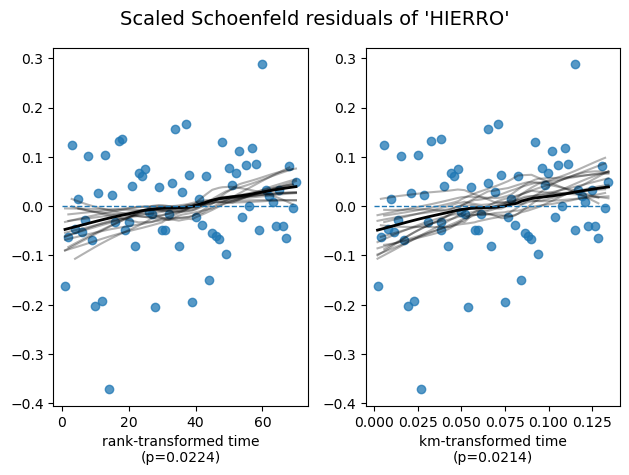

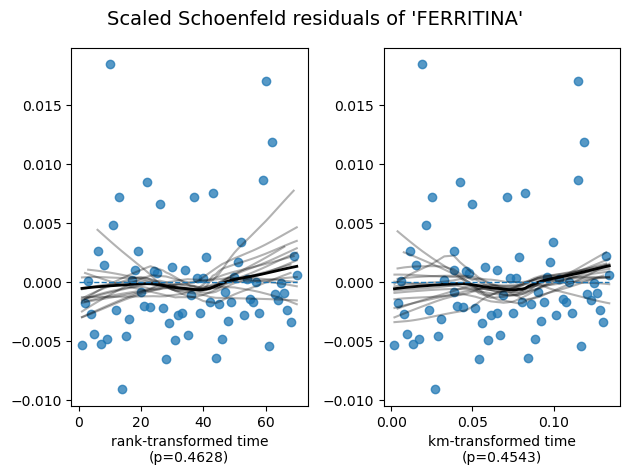

In [14]:
a.calculate_residuals(cph_per, cox_df_per, martingale=True, schonenfeld=False)
a.cox_visualization(cph_per, cox_df_per, survival_function=False, baseline_survival=True, baseline_cumulative_hazard=True, assumption=True) 

### COX non-proportional hazard alternatives

#### Extended COX (covariates anemia - peritonitis)

/opt/conda/lib/python3.11/site-packages/lifelines/fitters/cox_time_varying_fitter.py:817: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004230398113477267' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  baseline_hazard_.loc[t] = death_counts / hazards_at_t.sum()


<lifelines.CoxTimeVaryingFitter: fitted with 1770 periods, 521 subjects, 19 events>
         event col = 'event_col'
number of subjects = 521
 number of periods = 1770
  number of events = 19
partial log-likelihood = -111.66
  time fit was run = 2024-05-23 15:21:45 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA -0.02      0.98      0.13           -0.27            0.23                0.76                1.26
IST          0.07      1.07      0.04           -0.00            0.14                1.00                1.15
HIERRO      -0.04      0.96      0.02           -0.08           -0.00                0.93                1.00
FERRITINA    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00 -0.15 0.88      0.18
IST            0.00  1.88 0.06      4.07
HIERRO         0.00 -2.21 0.03      5.21
FERRITINA      0.00  0.44 0.66      0.61
---
Partial AIC = 231.32
log-likelihood ratio test = 6.19 on 4 df
-log2(p) of ll-ratio test = 2.43

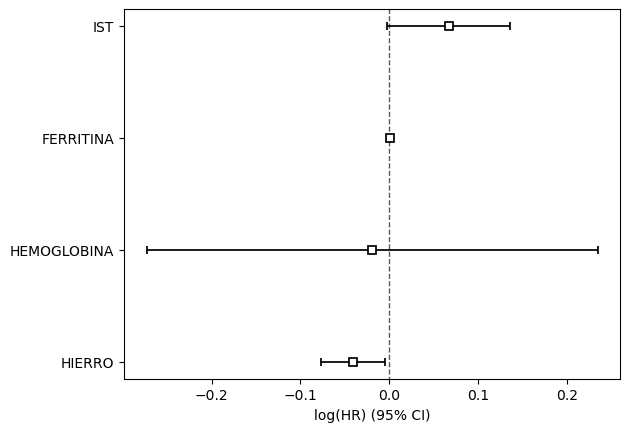

In [15]:
extended_cox_df = a.prepare_extended_cox_df(lab_df, per_df, covariate_list, study_time=365)

# Initialize the CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

# Fit the data to the model
ctv.fit(extended_cox_df, id_col='REGISTRO', event_col='event_col', start_col='start_col', stop_col='finish_col')

# Print the summary of the model
ctv.print_summary()

# Plot the coefficients of the model
ctv.plot()
plt.show()

#### Andersen-Gill anemia-peritonitis

The dataframe had 16507 rows (Unique patients: 1915), after the clean up of missing values, it has 8766 rows (Unique patients: 1248)
The dataframe had 8766 rows (Unique patients: 1248), after the clean up of missing values, it has 8723 rows (Unique patients: 1241)
The dataframe had 4342 rows (Unique patients: 2019), after the clean up of missing values, it has 4311 rows (Unique patients: 2011)
Number of rows before deleting: 8568
Number of rows deleted: 5
Total number of rows after deleting: 8563
Rows before excluding patients: 8563
Rows after excluding patients: 6318
Percentage of deleted rows: 26.217447156370433%
Rows before filter: 6318 (Unique patients: 943)
Rows after filter: 2800 (Unique patients: 793)
Rows before filter: 552 (Unique patients: 308)
Rows after filter: 208 (Unique patients: 166)


/opt/conda/lib/python3.11/site-packages/lifelines/fitters/cox_time_varying_fitter.py:817: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.008728407159851419' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  baseline_hazard_.loc[t] = death_counts / hazards_at_t.sum()


<lifelines.CoxTimeVaryingFitter: fitted with 2800 periods, 793 subjects, 41 events>
         event col = 'event_col'
number of subjects = 793
 number of periods = 2800
  number of events = 41
partial log-likelihood = -259.55
  time fit was run = 2024-05-23 15:21:50 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA  0.00      1.00      0.08           -0.15            0.15                0.86                1.17
IST          0.02      1.02      0.03           -0.05            0.08                0.96                1.08
HIERRO      -0.02      0.98      0.01           -0.05            0.00                0.95                1.00
FERRITINA    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00  0.04 0.97      0.05
IST            0.00  0.49 0.62      0.68
HIERRO         0.00 -1.61 0.11      3.23
FERRITINA      0.00  0.81 0.42      1.25
---
Partial AIC = 527.10
log-likelihood ratio test = 7.46 on 4 df
-log2(p) of ll-ratio test = 3.14

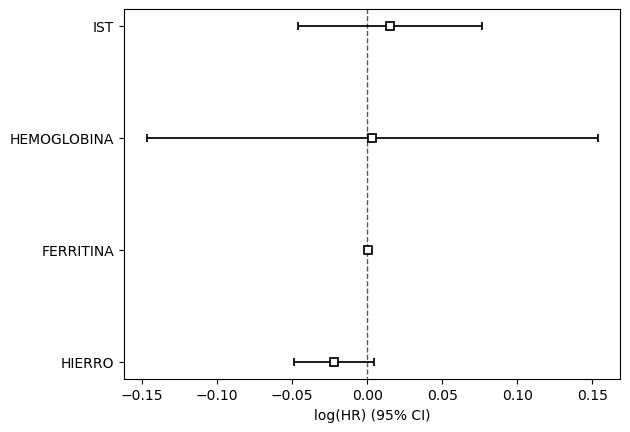

In [16]:
# Prepare the data
# Clean NaNs for interesting columns
lab_per_df = a.clean_df(merged_base_df, basic_cols_lab, verbose=True)
lab_per_df = a.clean_df(lab_per_df, covariate_list, verbose=True)
per_df = a.clean_df(per_base_df, basic_cols_per, verbose=True)

# Select years
lab_per_df, per_df = a.filter_by_year([lab_per_df, per_df], ['FECHA', 'FECHA'], 2010, 2023)

# Add anemia column based on 'HEMOGLOBINA' and 'SEXO' specified in KDIGO guidelines
a.add_anemia_column(lab_per_df)
a.add_age_column(lab_per_df)
a.add_ckd_column(lab_per_df)

# Delete rows that have 0 as values for not_zero_cols

lab_per_df = a.clean_zero_values(lab_per_df, not_zero_cols, verbose=True)

# Fill empty values for bool_cols
lab_per_df = a.bool_col_convert(lab_per_df, bool_col_list)

# Exclude patients with exclude_list
exclude_per_list = ['ITU', 'EPOC', 'NEO', 'SIST']
#exclude_list = ['TBC', 'CH', 'SIST', 'CARDIO', 'VP', 'VC', 'NEO', 'DIVERT']
lab_per_df = a.exclude_patients(lab_per_df, exclude_per_list, verbose=True)

# Add days since the start of pd for every column in both dataframes
lab_per_df = a.add_days_since_start(lab_per_df, lab_per_df, 'FECHA')
per_df = a.add_days_since_start(lab_per_df, per_df, 'FECHA')

# Now keep only the first year after the patients started PD
lab_per_df = a.filter_df(lab_per_df, 'days_since_start', 0, (365), verbose=True)
per_df = a.filter_df(per_df, 'days_since_start', 0, (365), verbose=True)

ag_df = a.prepare_andersen_gill_df(lab_per_df, per_df, covariate_list, study_time=365)

# Initialize the CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

# Fit the data to the model
ctv.fit(ag_df, id_col='REGISTRO', event_col='event_col', start_col='start_col', stop_col='finish_col')

# Print the summary of the model
ctv.print_summary()

# Plot the coefficients of the model
ctv.plot()
plt.show()

#### Extended COX diff filter

/opt/conda/lib/python3.11/site-packages/lifelines/fitters/cox_time_varying_fitter.py:817: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.008728407159851419' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  baseline_hazard_.loc[t] = death_counts / hazards_at_t.sum()


<lifelines.CoxTimeVaryingFitter: fitted with 2800 periods, 793 subjects, 41 events>
         event col = 'event_col'
number of subjects = 793
 number of periods = 2800
  number of events = 41
partial log-likelihood = -259.55
  time fit was run = 2024-05-23 15:21:54 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
HEMOGLOBINA  0.00      1.00      0.08           -0.15            0.15                0.86                1.17
IST          0.02      1.02      0.03           -0.05            0.08                0.96                1.08
HIERRO      -0.02      0.98      0.01           -0.05            0.00                0.95                1.00
FERRITINA    0.00      1.00      0.00           -0.00            0.00                1.00                1.00

             cmp to     z    p  -log2(p)
covariate                               
HEMOGLOBINA    0.00  0.04 0.97      0.05
IST            0.00  0.49 0.62      0.68
HIERRO         0.00 -1.61 0.11      3.23
FERRITINA      0.00  0.81 0.42      1.25
---
Partial AIC = 527.10
log-likelihood ratio test = 7.46 on 4 df
-log2(p) of ll-ratio test = 3.14

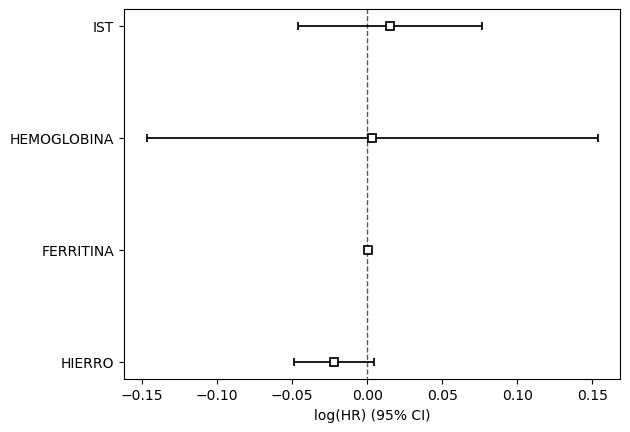

In [17]:
extended_cox_df = a.prepare_extended_cox_df(lab_per_df, per_df, covariate_list, study_time=365)

# Initialize the CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

# Fit the data to the model
ctv.fit(ag_df, id_col='REGISTRO', event_col='event_col', start_col='start_col', stop_col='finish_col')

# Print the summary of the model
ctv.print_summary()

# Plot the coefficients of the model
ctv.plot()
plt.show()

#### Random Survival Forest anemia - peritonitis

In [18]:
rsf_df, y =a.prepare_rsf_df(lab_df, hosp_df, covariate_list)

rsf = RandomSurvivalForest(n_estimators=1000)
rsf.fit(rsf_df, y)

RandomSurvivalForest(n_estimators=1000)

## Prevalencia de anemia en pacientes con ERC en DP

### Anemia prevalence stacked and by gener

The dataframe had 16507 rows (Unique patients: 1915), after the clean up of missing values, it has 9132 rows (Unique patients: 1353)


/home/jovyan/work/Medicina/LevanteDPAnemia/anemiaLevanteDP.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['ANEMIA'] = input_df.apply(check_anemia, axis=1)


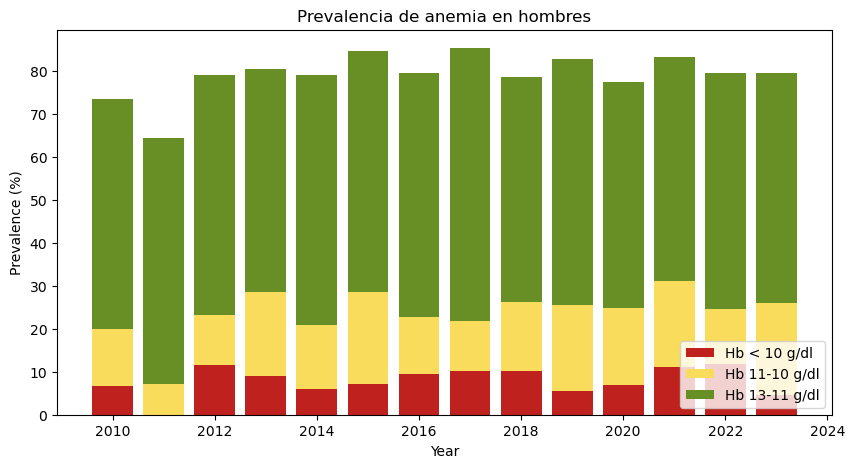

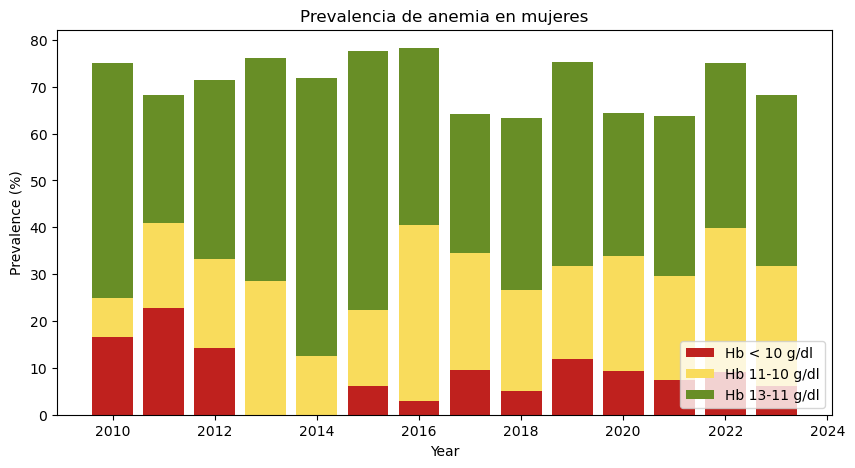

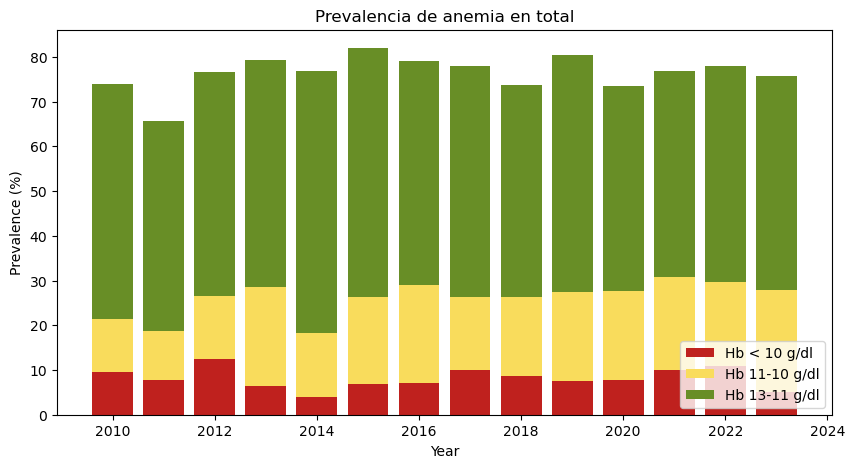

Lowest value year 2011: 65.625
Highest value year 2015: 81.9548872180451
{2010: {'Hb < 10 g/dl': 9.523809523809524, 'Hb 11-10 g/dl': 11.904761904761903, 'Hb 13-11 g/dl': 52.38095238095239}, 2011: {'Hb < 10 g/dl': 7.8125, 'Hb 11-10 g/dl': 10.9375, 'Hb 13-11 g/dl': 46.875}, 2012: {'Hb < 10 g/dl': 12.5, 'Hb 11-10 g/dl': 14.0625, 'Hb 13-11 g/dl': 50.0}, 2013: {'Hb < 10 g/dl': 6.493506493506493, 'Hb 11-10 g/dl': 22.07792207792208, 'Hb 13-11 g/dl': 50.649350649350644}, 2014: {'Hb < 10 g/dl': 4.040404040404041, 'Hb 11-10 g/dl': 14.14141414141414, 'Hb 13-11 g/dl': 58.58585858585859}, 2015: {'Hb < 10 g/dl': 6.7669172932330826, 'Hb 11-10 g/dl': 19.548872180451127, 'Hb 13-11 g/dl': 55.639097744360896}, 2016: {'Hb < 10 g/dl': 7.142857142857142, 'Hb 11-10 g/dl': 21.93877551020408, 'Hb 13-11 g/dl': 50.0}, 2017: {'Hb < 10 g/dl': 10.0, 'Hb 11-10 g/dl': 16.25, 'Hb 13-11 g/dl': 51.66666666666667}, 2018: {'Hb < 10 g/dl': 8.552631578947368, 'Hb 11-10 g/dl': 17.763157894736842, 'Hb 13-11 g/dl': 47.36842105

In [19]:
anemia_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'REGISTRO', 'FECHA']
anemia_df = a.clean_df(merged_base_df, anemia_cols, verbose=True)
a.add_anemia_column(anemia_df)
anemia_df = a.filter_by_year([anemia_df], ['FECHA'], 2010, 2023)[0]

ale_results_readable, female_results_readable, total_results_readable, df = a.anemia_prevalence_stack(anemia_df, [10, 11, 13], [10, 11, 12], [2010, 2023], print_maxmin=True)
print(total_results_readable)

## Tendencias marcadores de anemia

In [20]:
# Calculate the average time between labs

time_between_labs = a.lab_freq_stats(anemia_df, print_avg=True, print_patient=False)

Global average time between tests = 123.35949120529813 days


The dataframe had 16507 rows (Unique patients: 1915), after the clean up of missing values, it has 8806 rows (Unique patients: 1271)


/home/jovyan/work/Medicina/LevanteDPAnemia/anemiaLevanteDP.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['INICIO_DP'] = pd.to_datetime(input_df['INICIO_DP'])
/home/jovyan/work/Medicina/LevanteDPAnemia/anemiaLevanteDP.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['NACIMIENTO'] = pd.to_datetime(input_df['NACIMIENTO'])
/home/jovyan/work/Medicina/LevanteDPAnemia/anemiaLevanteDP.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

HEMOGLOBINA: p-value = 7.828191930111024e-38
HIERRO: p-value = 0.30800175101152427
IST: p-value = 0.6263432858609941
FERRITINA: p-value = 0.7435131663253879
CKD_CALC: p-value = 0.7673126291281663


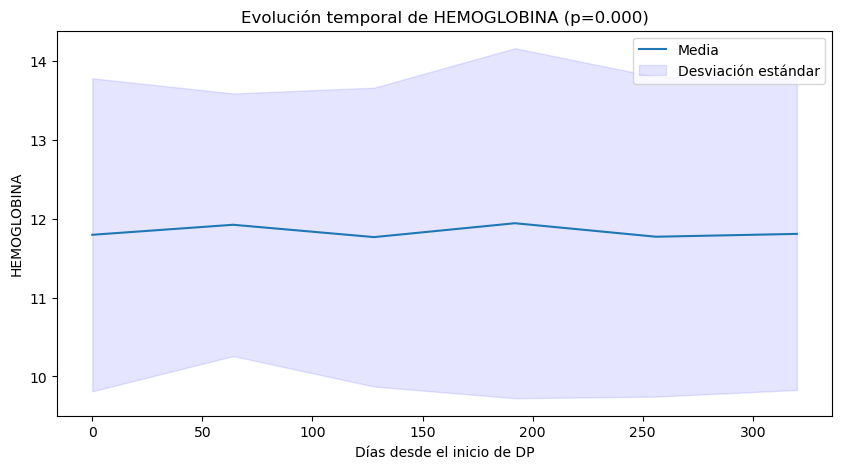

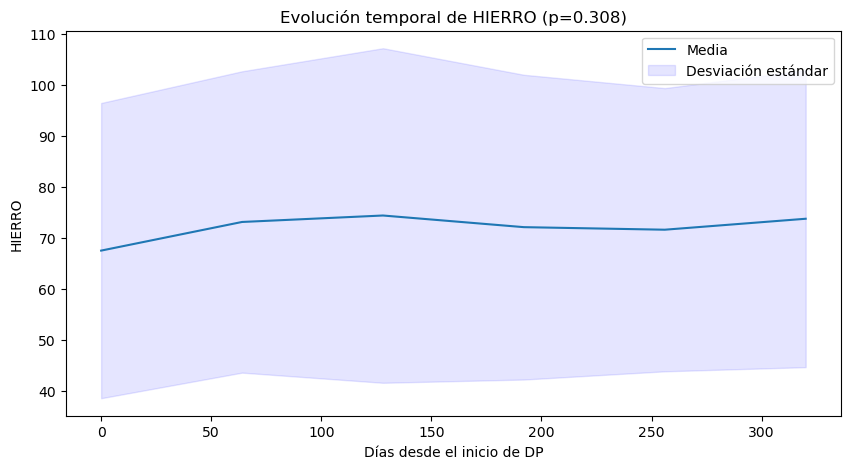

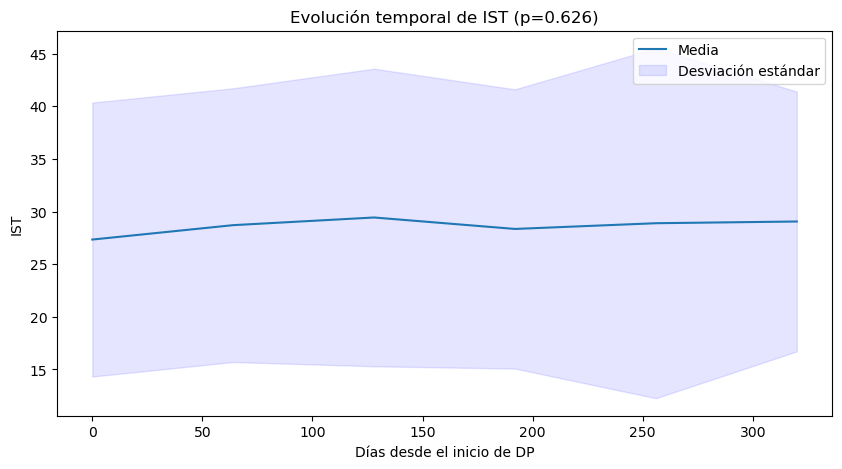

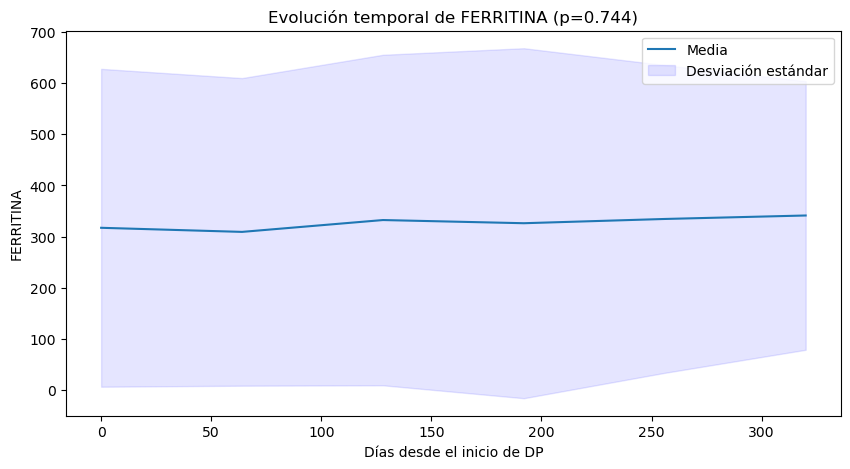

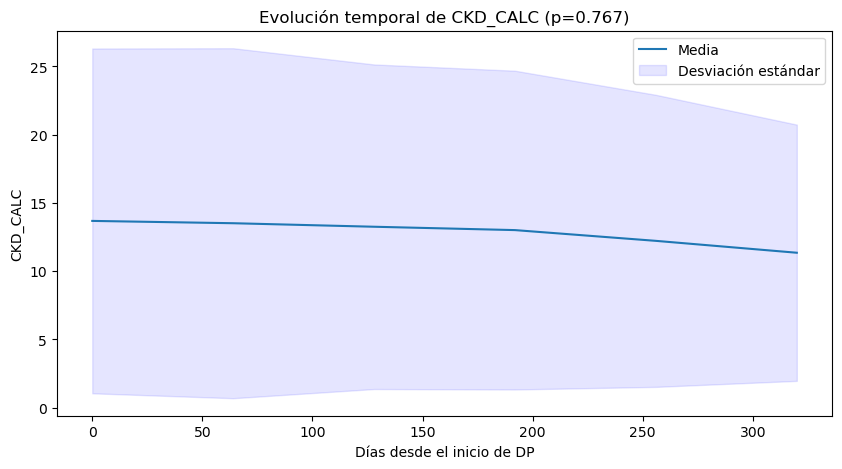

In [21]:
time_trend_cols = ['HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'CKD_CALC']
basic_cols = ['REGISTRO', 'FECHA','HEMOGLOBINA', 'HIERRO', 'IST', 'FERRITINA', 'INICIO_DP', 'NACIMIENTO']

anemia_df = a.clean_df(merged_base_df, basic_cols, verbose=True)
a.add_age_column(anemia_df)
a.add_ckd_column(anemia_df)

time_trend_df = a.time_trend_analysis(anemia_df, 64, time_trend_cols, 365, plot_results=True, t_test=True, normality_test=False)

In [22]:
a.stationary_test(time_trend_df, col_str='_avg')

Testing for stationarity in column: HEMOGLOBINA_avg
ADF Statistic: -3.810212
p-value: 0.002805
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in HEMOGLOBINA_avg is stationary.

Testing for stationarity in column: HIERRO_avg
ADF Statistic: -4.052538
p-value: 0.001159
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in HIERRO_avg is stationary.

Testing for stationarity in column: IST_avg
ADF Statistic: -10.604696
p-value: 0.000000
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in IST_avg is stationary.

Testing for stationarity in column: FERRITINA_avg
ADF Statistic: -0.954343
p-value: 0.769551
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in FERRITINA_avg is not stationary and may need differencing.

Testing for stationarity in column: CKD_CALC_avg
ADF Statistic: 2.429775
p-value: 0.999024
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
The data in CKD_CALC_avg is not stationary and may need differencing.



## Baseline

In [23]:
baseline = a.calculate_baseline(lab_df, baseline_cat_cols, baseline_num_cols, print_results=True)

SEXO:
    counts: SEXO
1. Hombre    329
2. Mujer     192
Name: count, dtype: int64
    percentages: SEXO
1. Hombre    63.147793
2. Mujer     36.852207
Name: count, dtype: float64

CKD_STAGE:
    counts: CKD_STAGE
Stage 5     499
Stage 4      19
Stage 3B      2
Stage 3A      1
Name: count, dtype: int64
    percentages: CKD_STAGE
Stage 5     95.777351
Stage 4      3.646833
Stage 3B     0.383877
Stage 3A     0.191939
Name: count, dtype: float64

ARRITMIA:
    counts: ARRITMIA
False            489
True              19
Missing_value     13
Name: count, dtype: int64
    percentages: ARRITMIA
False            93.857965
True              3.646833
Missing_value     2.495202
Name: count, dtype: float64

ITU:
    counts: ITU
Missing_value    286
False            226
True               9
Name: count, dtype: int64
    percentages: ITU
Missing_value    54.894434
False            43.378119
True              1.727447
Name: count, dtype: float64

TBC:
    counts: TBC
Missing_value    286
False         